# Imports


In [1]:
from utils.experiment import *
from utils.transforms import *
from utils.train import HParams

# ✔️ Baseline

- Basic normalization
  - normalize values between 0 and 1 because images from the different datasets have different value ranges in the images
  - equalizeHist to have a unified brightness and contrast
  - normalize mean because it normalizes statistical properties of the images and is a recommended and often used step
  - same for standardization
- warum diese reihenfolge?


Running Experiment >>Baseline<<
Reading data took 0.7s


Train progress: [                              ] 0/7370 Epoch: --- Loss: ------
Train progress: [                           ] 0/7370 Epoch: 1/10 Loss: ↘ 1.0978
Train progress: [                          ] 10/7370 Epoch: 1/10 Loss: ↘ 1.0754
Train progress: [                          ] 20/7370 Epoch: 1/10 Loss: ↘ 1.0750
Train progress: [                          ] 30/7370 Epoch: 1/10 Loss: ↘ 0.9976
Train progress: [                          ] 40/7370 Epoch: 1/10 Loss: ↘ 0.9902
Train progress: [                          ] 50/7370 Epoch: 1/10 Loss: ↗ 1.0133
Train progress: [                          ] 60/7370 Epoch: 1/10 Loss: ↗ 1.0161
Train progress: [                          ] 70/7370 Epoch: 1/10 Loss: ↗ 1.0878
Train progress: [                          ] 80/7370 Epoch: 1/10 Loss: ↘ 0.9581
Train progress: [                          ] 90/7370 Epoch: 1/10 Loss: ↗ 1.0499
Train progress: [                         ] 100/7370 Epoch: 1/10 Loss: ↘ 0.9647
Train progress: [                       

1. Training took 24m 51.1s
1. Evaluation took 11.4s
Successfully ran Experiment >>Baseline<<


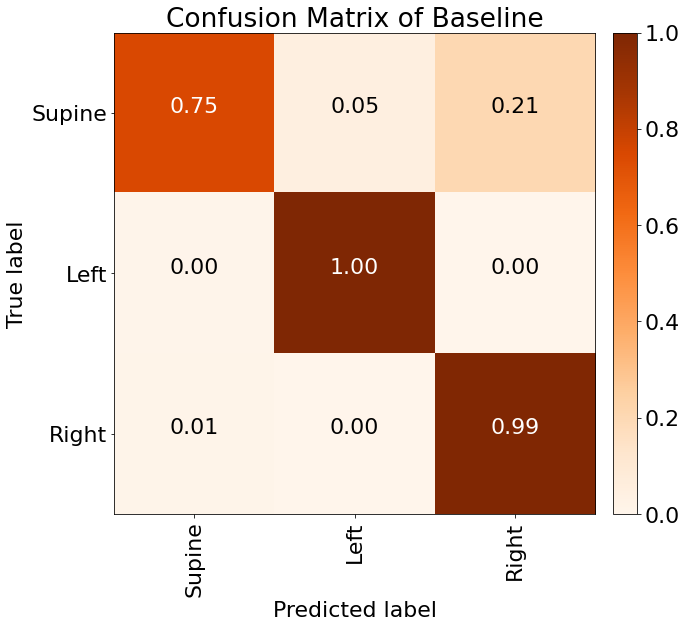

In [2]:
normalization = [
    Resize((32, 64)),
    Standardize(),
    NormalizeMinMax(),
    EqualizeHist(),
    Resize((64, 128)),
]

baseline = Experiment("Baseline", normalization + [ToTensor()], hparams=HParams(num_trainings=1)).run()

# ✔️ No Preprocessing

In [3]:
no_preprocessing = Experiment("No Preprocessing", [Resize((64, 128)), ToTensor()])

# ✔️ CLAHE

In [4]:
clahe = Experiment(
    "CLAHE",
    [
        Resize((32, 64)),
        Standardize(),
        NormalizeMinMax(),
        CLAHE(),
        Resize((64, 128)),
        ToTensor(),
    ],
)

# ✔️ Agressive Thresholding
- One could also try out different thresholding algorithms, but there was no difference in my case, but maybe in combination with other preprocessing steps it might make a difference. skimage provides a function for plotting the results of the provided thresholding algorithms

In [5]:
agressive_thresholding = Experiment(
    "Agressive Thresholding",
    [
        *normalization,
        Blur((3, 3)),
        Threshold(median_larger_zero),
        ToTensor(),
    ],
)


# ✔️ Agressive Thresholding + Sobel


In [6]:
sobel = Experiment(
    "Agressive Thresholding + Sobel",
    [
        *normalization,
        Blur((3, 3)),
        Threshold(median_larger_zero),
        Sobel(),
        Threshold(median_larger_zero),
        ToTensor(),
    ],
)


# ✔️ Rolling Ball + Agressive Thresholding


In [7]:
rolling_ball = Experiment("Rolling Ball + Agressive Thresholding",
    [
        *normalization,
        RollingBall(radius=5),
        Blur((3, 3)),
        Threshold(median_larger_zero),
        ToTensor(),
    ]
)


# ✔️ Simple denoise
- comparison to agressive thresholding and rolling ball + thresholding which noise removal methods has the best result
- try different denoise functions?

In [8]:
simple_denoise = Experiment("Simple Denoise",
    [
        *normalization,
        Denoise(),
        Threshold(median_larger_zero),
        ToTensor(),
    ]
)

# ✔️ Fourier


In [9]:
fourier = Experiment("Fourier",
    [
        *normalization,
        Denoise(),
        Blur((3, 3)),
        HighPass(rad=50),
        Blur((3, 3)),
        Threshold(median_larger_zero),
        ToTensor(),
    ]
)


# ✔️ Improving SLP

- hier zwei szenarien testen: einmal diese transformation auf beide datensätze anwenden und einmal nur auf slp und agressive thresholding oder so auf physionet
- interessante sache: später resizen behält in den schritten davor noch mehr details, womit besser preprocessed werden kann
- Potential: Menschen auf slp bildern vergrößern, damit die auf allen druckbildern ungefähr gleich groß sind


In [10]:
improve_slp = Experiment("Improve SLP",
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Blur((3, 3)),
        Denoise(),
        Threshold(median_larger_zero),
        Close((3, 3), ktype=cv2.MORPH_CROSS, iterations=3),
        Blur((3, 3)),
        Resize((64, 128)),
        ToTensor(),
    ]
)


# ✔️ Radial Transform
- als preprocessing schritt mit center origin
- als data augmentation schritt mit random origin

In [11]:
radial_transform = Experiment("Radial Transform",
    [
        *normalization,
        Blur((3, 3)),
        Threshold(median_larger_zero),
        WarpPolar(),
        ToTensor(),
    ]
)


# ✔️ Radial Transform on Sobel

In [12]:
radial_transform_sobel = Experiment("Radial Transform on Sobel",
    [
        *normalization,
        Blur((3, 3)),
        Threshold(median_larger_zero),
        Sobel(),
        Threshold(median_larger_zero),
        WarpPolar(),
        ToTensor(),
    ]
)


# ✔️ Dynamic Closing
-> Future Work: Look at each segment of the image instead of the whole image at once and do local dynamic closing

In [13]:
dynamic_closing = Experiment("Dynamic Closing",
    [
        *normalization,
        Blur((3, 3)),
        Threshold(median_larger_zero),
        CloseInHoughDirection(),
        ToTensor(),
    ]
)

# ✔️ Individual Transform

In [14]:
individual_tranform = Experiment(
    "Individual Transform",
    transform=[ # Agressive Thresholding
        *normalization,
        Blur((3, 3)),
        Threshold(median_larger_zero),
        ToTensor(),
    ],
    transform_slp=[ # Improve SLP
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Blur((3, 3)),
        Denoise(),
        Threshold(median_larger_zero),
        Close((3, 3), ktype=cv2.MORPH_CROSS, iterations=3),
        Blur((3, 3)),
        Resize((64, 128)),
        ToTensor(),
    ],
)

# ✔️ Random Rotate

In [15]:
random_rotate = Experiment(
    "Random Rotate",
    [
        *normalization,
        Blur((3, 3)),
        Threshold(median_larger_zero),
        RandomRotate(30),
        ToTensor(),
    ],
)

# ✔️ Random Rotate + Zoom

In [16]:
random_rotate_zoom = Experiment(
    "Random Rotate Zoom",
    [
        *normalization,
        Blur((3, 3)),
        Threshold(median_larger_zero),
        RandomRotate(30),
        RandomZoom((128, 64)),
        ToTensor(),
    ],
)

# ✔️ Multichannel

In [2]:
multichannel = Experiment(
    "Multichannel",
    [
        Resize((64, 128)),
        Combine(
            [
                [
                    Standardize(),
                    NormalizeMinMax(),
                    EqualizeHist(),
                    Blur((3, 3)),
                    Threshold(median_larger_zero),
                ],
                [
                    Standardize(),
                    NormalizeMinMax(),
                    EqualizeHist(),
                    Blur((3, 3)),
                    Threshold(median_larger_zero),
                    WarpPolar(),
                ],
            ]
        ),
        ToTensor(),
    ],
)

# ✔️ Multichannel with Baseline

In [3]:
multichannel_baseline = Experiment(
    "Multichannel with Baseline",
    [
        Resize((64, 128)),
        Combine(
            [
                [
                    Standardize(),
                    NormalizeMinMax(),
                    EqualizeHist(),
                ],
                [
                    Standardize(),
                    NormalizeMinMax(),
                    EqualizeHist(),
                    Blur((3, 3)),
                    Threshold(median_larger_zero),
                    WarpPolar(),
                ],
            ]
        ),
        ToTensor(),
    ],
)

# ✔️ Multichannel with Original

In [4]:
multichannel_original = Experiment(
    "Multichannel with Original",
    [
        Resize((64, 128)),
        Combine(
            [
                [],
                [
                    Standardize(),
                    NormalizeMinMax(),
                    EqualizeHist(),
                    Blur((3, 3)),
                    Threshold(median_larger_zero),
                    WarpPolar(),
                ],
            ]
        ),
        ToTensor(),
    ],
)

# Evaluation

Running Experiment >>Baseline<<
Reading data took 0.9s


Train progress: [                              ] 0/6420 Epoch: --- Loss: ------
Train progress: [                           ] 0/6420 Epoch: 1/10 Loss: ↘ 1.0986
Train progress: [                          ] 10/6420 Epoch: 1/10 Loss: ↘ 1.0807
Train progress: [                          ] 20/6420 Epoch: 1/10 Loss: ↘ 0.9805
Train progress: [                          ] 30/6420 Epoch: 1/10 Loss: ↗ 0.9903
Train progress: [                          ] 40/6420 Epoch: 1/10 Loss: ↘ 0.9823
Train progress: [                          ] 50/6420 Epoch: 1/10 Loss: ↘ 0.8914
Train progress: [                          ] 60/6420 Epoch: 1/10 Loss: ↗ 1.0153
Train progress: [                          ] 70/6420 Epoch: 1/10 Loss: ↘ 0.8636
Train progress: [                          ] 80/6420 Epoch: 1/10 Loss: ↗ 1.0346
Train progress: [                          ] 90/6420 Epoch: 1/10 Loss: ↘ 0.8971
Train progress: [                         ] 100/6420 Epoch: 1/10 Loss: ↘ 0.8138
Train progress: [                       

1. Training took 20m 7.8s
1. Evaluation took 10.4s
Successfully ran Experiment >>Baseline<<


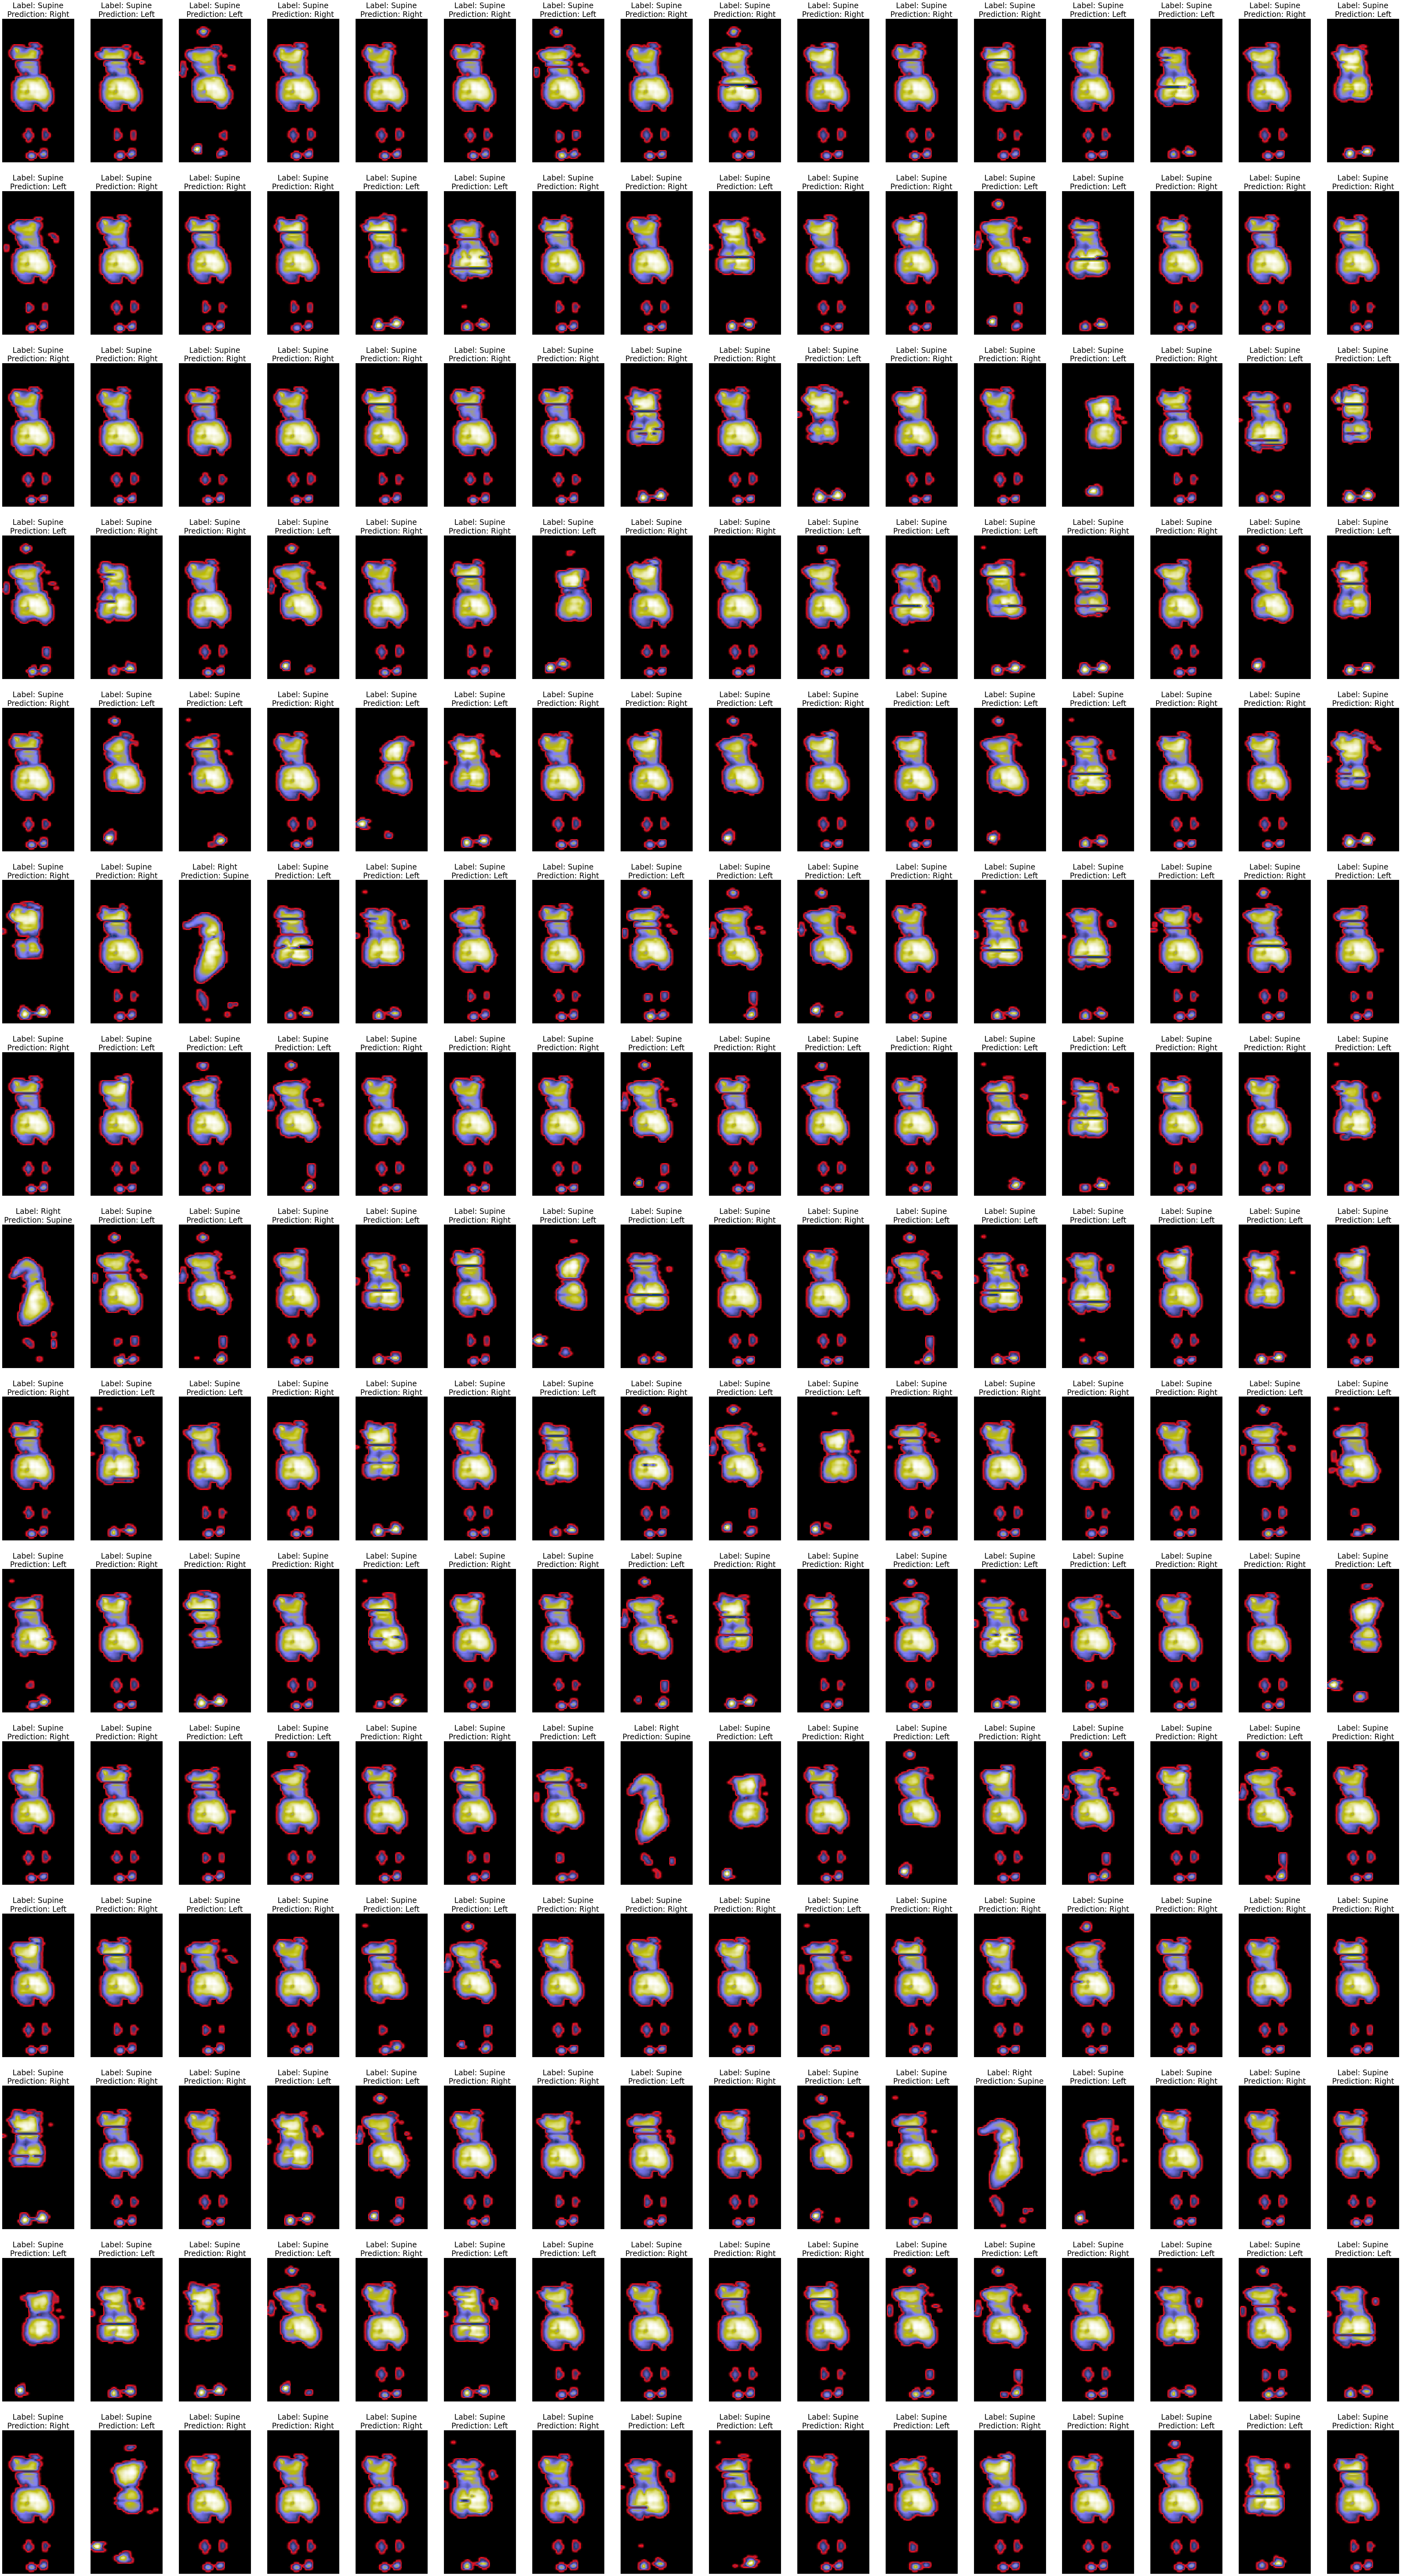

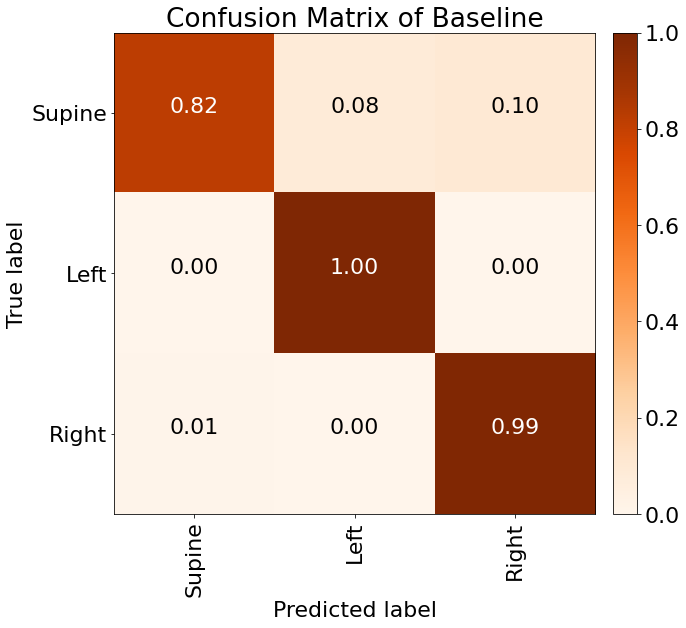

In [4]:
experiments = [baseline]

for experiment in experiments:
    experiment.run()